In [14]:
import numpy as np
import torch
import argparse
import json
import sys
from pathlib import Path
import _pickle as cPickle
import numpy as np
import torch.nn as nn
from natsort import natsorted
from torch import optim
from PIL import Image
from tqdm import tqdm
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import scipy.io as sio
from matplotlib.patches import Rectangle
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
sys.path.append("modules/helpers")
sys.path.append("configs")
sys.path.append("common")

import robust_loss_pytorch.general
from mv_nrsfm_configs import get_dictionary, get_seed
from mvnrsfm.neural_prior_modules import (
    BlockSparseCodingLayer,
    CameraEstimator,
    OnPEstimator,
    SparseCodeExtractionLayer,
    VecSparseCodingLayer,
)
from util_cameras import normalize_3d_structure, procrustes_align
from util_common import get_device, make_dir, parse_boolean, extract_bone_connections, get_colors
from util_errors import computeMPJPE, error_ratio


In [15]:
""" Parameters """
dataset = "Cheetah"

params = {"model": "models/" + dataset, \
          "batch": 1000, \
          "dataset": dataset, \
          "dataset_metric_multiplier": 1000, \
          "img_type": ".jpg"
          }

In [16]:
class MVNRSfM(nn.Module):
    """
    Class containing all the parameters for the MultiView Non-Rigid Structure-from-Motion.
    Lifts 2D to 3D
    """

    def __init__(
        self,
        params,
        GT_Flag=False,
        DEVICE="cuda",
        num_joints=21,
        total_views=4,
        total_frames=1000,
        dict_list=list(np.arange(125, 7, -10)),
    ):
        """
        Initialize the BaseAPI object
        :param num_joints: number of joints
        :param dict_list: sparse dictionary dimensions

        """
        # Necessary for proper multiple sub-classing
        super(MVNRSfM, self).__init__()
        self.model_path = params["model"]  # model path or trained weights path
        self.from_scratch = False
        self.DEVICE = DEVICE
        self.num_joints = num_joints
        self.total_views = total_views
        self.total_frames = total_frames
        share_weight = True  # Share weights b/w Encoder and Decoder Dictionaries

        # Neural Prior Module
        self.sparse_coding_layers = nn.ModuleList(
            [VecSparseCodingLayer(dict_list[0], num_joints, share_weight)]
        )
        for idx in range(1, len(dict_list)):
            self.sparse_coding_layers.append(
                BlockSparseCodingLayer(dict_list[idx], dict_list[idx - 1], share_weight)
            )
        self.code_estimator = SparseCodeExtractionLayer(code_dim=dict_list[-1], is_2d=True)
        self.GT_Flag = GT_Flag

        # Camera Module
        self.onp_estimator = OnPEstimator()

        # MV-NRSfM Training
        if ~self.GT_Flag:
            self.unit_scale = True
        self.dataset_metric_multiplier = params["dataset_metric_multiplier"]
        self.dict_dims = dict_list
        self.log_dir = params["model"]
        self.print_freq = 50
        self.save_freq = 1000
        self.lr = 0.0001
        self.max_itr = 1000000
        self.lr_decay_step = 5000
        self.lr_decay_rate = 0.95
        self.validation_freq = 1000
        self.batch = params["model"]
        self.bottleneck_size = dict_list[-1]

        # Load model
        if self.DEVICE.type == "cpu":
            self.model = self.load_state_dict(
                torch.load(params["model"] + "/model_best.pth", map_location=torch.device("cpu"))
            )
        else:
            self.model = self.load_state_dict(torch.load(params["model"] + "/model_best.pth"))

    def save_model(self, checkpoint_file):
        torch.save(self.state_dict(), checkpoint_file)

    def get_parameters(self):
        return self.model.parameters()

    def get_trace3d(self, joint_connections, points3d, point_color=None, line_color=None, name="PointCloud"):
        """Yields plotly traces for visualization"""
        if point_color is None:
            point_color = "rgb(30, 20, 160)"
        if line_color is None:
            line_color = "rgb(30, 20, 160)"

        # Trace of points
        trace_pts = go.Scatter3d(
            x=points3d[:, 0],
            y=points3d[:, 2],
            z=points3d[:, 1],
            mode="markers",
            name=name,
            marker=dict(symbol="circle", size=6, color=point_color),
        )

        # Trace of line
        xlines, ylines, zlines = [], [], []
        for line in joint_connections:
            for point in line:
                xlines.append(points3d[point, 0])
                ylines.append(points3d[point, 2])
                zlines.append(points3d[point, 1])
            xlines.append(None)
            ylines.append(None)
            zlines.append(None)
        trace_lines = go.Scatter3d(
            x=xlines, y=ylines, z=zlines, mode="lines", name=name, line=dict(width=6, color=line_color)
        )

        return [trace_pts, trace_lines]


    def get_figure3d(
        self, joint_connections, input_cam_x, input_cam_y, points3d, points3d_gt, range_scale=2500
    ):
        """Yields plotly figure for visualization"""
        color_palette = get_colors()
        color_blue, color_red = color_palette["color_blue"], color_palette["color_red"]
        traces = self.get_trace3d(joint_connections, points3d, color_blue, color_blue, "Predicted KP")
        if points3d_gt is not None:
            traces += self.get_trace3d(
                joint_connections, points3d_gt, color_red, color_red, "Groundtruth KP"
            )

        layout = go.Layout(
            scene=dict(
                aspectratio=dict(x=0.8, y=0.8, z=2),
                xaxis=dict(range=(-0.4 * range_scale, 0.4 * range_scale)),
                yaxis=dict(range=(-0.4 * range_scale, 0.4 * range_scale)),
                zaxis=dict(range=(-1 * range_scale, 1 * range_scale)),
            ),
            width=700,
            margin=dict(r=20, l=10, b=10, t=10),
            scene_camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=input_cam_x, y=input_cam_y, z=1.25),
            ),
        )
        return go.Figure(data=traces, layout=layout)

    def gen_image(self, im, W_GT, W_Predictions, joint_connections):
        
        subplots = plt.subplots(1, 2)

        fig = subplots[0]
        axes = subplots[1]

        for idx in range(2):        
            axes[idx].imshow(im)

            if idx == 0:
                W = W_GT
                color_kpts = "r"
                fontdict = {"fontsize": 50, "color": color_kpts}                
                axes[idx].axes.set_title("Grountruth", fontdict)
            elif idx == 1:
                W = W_Predictions
                color_kpts = "b"
                fontdict = {"fontsize": 50, "color": color_kpts}
                axes[idx].axes.set_title("Prediction", fontdict)
            axes[idx].scatter(x=W[:, 0], y=W[:, 1], c=color_kpts, s=40)
            xlines, ylines = extract_bone_connections(W, joint_connections)
            axes[idx].plot(xlines, ylines, c=color_kpts, linewidth=4)            
            axes[idx].axes.xaxis.set_visible(False)
            axes[idx].axes.yaxis.set_visible(False)

        figure = plt.gcf()
        figure.set_size_inches(38, 36)

        return figure


    def forward(self, pts_2d_packet):
        layer_num = len(self.sparse_coding_layers)
        code_inner = (
            torch.from_numpy(
                np.zeros((len(pts_2d_packet), pts_2d_packet[0].shape[0], self.dict_dims[-1], 1, 1))
            )
            .float()
            .to(self.DEVICE)
        )

        """ Encode the 2D representation. """
        camera_matrix = []
        for outer_idx in range(len(pts_2d_packet)):
            flag_nan = ~torch.any(torch.any(torch.isnan(pts_2d_packet[outer_idx]), dim=1), dim=1)
            code_block = pts_2d_packet[outer_idx]
            code_block = code_block[flag_nan]
            indices_non_nan = torch.nonzero(flag_nan.float()).view(-1)
            for idx in range(layer_num):
                code_block = self.sparse_coding_layers[idx].encode_with_cam(code_block)

            code_inner[outer_idx, indices_non_nan, :, :, :] = (
                self.code_estimator(code_block).float().to(self.DEVICE)
            )

        """ Enforce multi-view consistency by pooling the codes from all the views. """
        code_pooled = torch.sum(code_inner, dim=0) / len(pts_2d_packet)
        code_canon = code_pooled.clone()

        """ Decode the pooled code and generate 3D structure in a canonical frame. """
        for idx in range(layer_num - 1, 0, -1):
            code_pooled = self.sparse_coding_layers[idx].decode(code_pooled)
        pts_recon_canonical, dict_final_pass = self.sparse_coding_layers[0].decode(code_pooled)
        W_cat = torch.cat((pts_2d_packet), dim=0)
        S_cat_pred = torch.cat([pts_recon_canonical] * len(pts_2d_packet))
        flag_nan = ~torch.any(torch.any(torch.isnan(W_cat), dim=1), dim=1)

        """ Estimate the camera using least squares algebraic solution of OnP """
        pts_2d_reproj, pts_3d_recon, cam_matrix, rotation_matrix = self.onp_estimator(
            W_cat[flag_nan], S_cat_pred[flag_nan]
        )

        prediction = (
            pts_3d_recon,
            pts_2d_reproj,
            W_cat,
            code_canon,
            cam_matrix,
            pts_recon_canonical,
        )

        return prediction, flag_nan

    def train(self, adaptive, input):
        prediction, flag_nan = self.forward(input)
        S_Pred, W_Pred, W_Input = (prediction[0], prediction[1], prediction[2])
        reprojection_loss = torch.mean(
            adaptive.lossfun(
                W_Pred.view(W_Pred.shape[0], W_Pred.shape[1] * W_Pred.shape[2])
                - W_Input[flag_nan].view(
                    W_Input[flag_nan].shape[0],
                    W_Input[flag_nan].shape[1] * W_Input[flag_nan].shape[2],
                )
            )
        )
        return reprojection_loss

    def validation(self, input):
        with torch.no_grad():
            W = input[0]
            T_Offset = torch.cat(input[1], dim=0)
            W_GT = torch.cat(input[2], dim=0)
            if self.GT_Flag:
                S_GT = torch.cat(input[3], dim=0)
            W_, S_, Errors_ = [], [], []
            prediction, flag_nan = self.forward(W)

            # All of the fields below are non-nan values. Fill them back in their respective size matrices.
            S_Pred, W_Pred, W_Input, code, cam, S_Canon = (
                prediction[0],
                prediction[1],
                prediction[2],
                prediction[3],
                prediction[4],
                prediction[5],
            )

            # Define full size
            dim_1, dim_2 = torch.cat(W, dim=0).shape[0], torch.cat(W, dim=0).shape[1]

            # Fill the full size matrices
            W_Pred = W_Pred + T_Offset[flag_nan]
            W_Input[flag_nan] = W_Input[flag_nan] + T_Offset[flag_nan]
            S_Pred_, W_Pred_ = (
                torch.zeros((dim_1, dim_2, 3)).to(self.DEVICE).float(),
                torch.zeros((dim_1, dim_2, 2)).to(self.DEVICE),
            )
            S_Pred_[:], W_Pred_[:] = torch.nan, torch.nan
            S_Pred_[flag_nan], W_Pred_[flag_nan] = S_Pred, W_Pred

            # Procrustes-Align if G.T. is available and pack the matrices to deliver back.
            if self.GT_Flag:
                # 3D Error
                S_Pred_ = procrustes_align(S_Pred_, S_GT)
                PA_MPJPE_3D = (
                    computeMPJPE(S_Pred_[flag_nan], S_GT[flag_nan]) * self.dataset_metric_multiplier
                )
                S_GT = S_GT.reshape(self.total_views, self.total_frames, self.num_joints, 3)
            else:
                S_Pred_ = normalize_3d_structure(S_Pred_)
                PA_MPJPE_3D = None

            non_nans = np.argwhere(
                ~np.any(np.any(np.isnan(W_Input.detach().cpu().numpy()), axis=1), axis=1) == True
            )[:, 0]

            W_GT = W_GT + T_Offset

            error_2D = (
                error_ratio(W_Pred_[non_nans], W_GT[non_nans]) * self.dataset_metric_multiplier
            )

            errors = {"2D_Error_Ratio": error_2D, "3D_PA_MPJPE": PA_MPJPE_3D}
            S_Pred_ = S_Pred_.reshape(self.total_views, self.total_frames, self.num_joints, 3)
            W_Pred_ = W_Pred_.reshape(self.total_views, self.total_frames, self.num_joints, 2)
            W_GT = W_GT.reshape(self.total_views, self.total_frames, self.num_joints, 2)
            W_Input = W_Input.reshape(self.total_views, self.total_frames, self.num_joints, 2)

        return errors, W_Pred_, S_Pred_, W_GT


In [17]:
""" GPU Device allotment """
DEVICE = get_device()

""" Extract joint connections """
with open("configs/joints/" + str(dataset) + ".json", "r") as fid:
    joints_data = json.load(fid)
joint_connections = joints_data["joint_connections"]
range_scale = joints_data["range_scale"]
rigid_rotation = joints_data["R"]

""" Extract annotation file paths """
annot_path = "data/" + str(dataset) + "/annot/"
pkl_names = []
for path in Path(annot_path).rglob("*.pkl"):
    pkl_names.append(path)
pkl_names = [Path(p) for p in natsorted([str(p) for p in pkl_names])]

""" Extract total number of views """
total_views = len(pkl_names)

""" Extract G.T. 2D and 3D if available, else only 2D """
""" Find total number of frames """
with open(str(pkl_names[0]), "rb") as fid:
    pickled_data = cPickle.load(fid)
total_frames = len(pickled_data)

""" Check whether the data has G.T. 2D and 3D """
if "S_GT" in pickled_data[0]:
    GT_Flag = True
else:
    GT_Flag = False

In [18]:
""" Load the data """
""" Find number of joints/keypoints """
num_joints = pickled_data[0]["W_GT"].shape[0]

W, W_GT, S_GT, T_Offset, confidence = [], [], [], [], []

""" Iterate over views """
for cam_idx in range(total_views):
    with open(pkl_names[cam_idx], "rb") as fid:
        pickled_data = cPickle.load(fid)
    # Iterate over frames
    W_, W_GT_, S_GT_, T_Offset_, confidence_ = [], [], [], [], []
    for frame_idx in range(total_frames):
        W_.append(pickled_data[frame_idx]["W_GT"])
        W_GT_.append(pickled_data[frame_idx]["W_GT"])
        if GT_Flag:
            S_GT_.append(pickled_data[frame_idx]["S_GT"])
    W_ = np.asarray(W_)
    W_GT_ = np.asarray(W_GT_)
    S_GT_ = np.asarray(S_GT_)

    non_nans = np.argwhere(np.asarray(confidence_) == False)[:, 0].tolist()
    W_[non_nans, :, :] = np.nan

    # Remove translation: Enforce object-centric assumptipn
    T_Offset_ = W_GT_.mean(1, keepdims=True)
    W_ = W_ - W_.mean(1, keepdims=True)
    W_GT_ = W_GT_ - T_Offset_
    if GT_Flag:
        S_GT_ = S_GT_ - S_GT_.mean(1, keepdims=True)

    W.append(torch.from_numpy(W_).to(DEVICE).float())
    W_GT.append(torch.from_numpy(W_GT_).to(DEVICE).float())
    S_GT.append(torch.from_numpy(S_GT_).to(DEVICE).float())
    T_Offset.append(torch.from_numpy(T_Offset_).to(DEVICE).float())

data_loaded = (W, T_Offset, W_GT, S_GT)


""" Load rotation, scale, and images if available """
R = rigid_rotation
mat_contents = sio.loadmat("common/cam_25_8.mat")
cam_x = mat_contents["x_final"][0].tolist()
cam_y = mat_contents["y_final"][0].tolist()
image_paths_cam = []
for cam_idx in range(total_views):
    image_paths_cam_ = []
    for path in Path("data/" + dataset + "/images/CAM_" + str(cam_idx + 1) + "/").rglob(
        "*" + str(params["img_type"])
    ):
        image_paths_cam_.append(path)
    image_paths_cam_ = [Path(p) for p in natsorted([str(p) for p in image_paths_cam_])]
    image_paths_cam.append(image_paths_cam_)

In [19]:
""" MV-NRSfM Dictionary """
dict_list = get_dictionary()

""" Load the Adaptive Loss function Kernel """
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims=num_joints * 2, float_dtype=torch.float32, device=DEVICE
)


In [20]:
""" Initialize the MV-NRSfM Kernel Class """
mv_nrsfm_kernel = MVNRSfM(
    params,
    GT_Flag,
    DEVICE,
    num_joints=num_joints,
    total_views=total_views,
    total_frames=total_frames,
    dict_list=dict_list,
)

mv_nrsfm_kernel.to(DEVICE)


MVNRSfM(
  (sparse_coding_layers): ModuleList(
    (0): VecSparseCodingLayer()
    (1): BlockSparseCodingLayer()
    (2): BlockSparseCodingLayer()
    (3): BlockSparseCodingLayer()
    (4): BlockSparseCodingLayer()
    (5): BlockSparseCodingLayer()
    (6): BlockSparseCodingLayer()
    (7): BlockSparseCodingLayer()
    (8): BlockSparseCodingLayer()
    (9): BlockSparseCodingLayer()
    (10): BlockSparseCodingLayer()
    (11): BlockSparseCodingLayer()
    (12): BlockSparseCodingLayer()
    (13): BlockSparseCodingLayer()
    (14): BlockSparseCodingLayer()
    (15): BlockSparseCodingLayer()
    (16): BlockSparseCodingLayer()
    (17): BlockSparseCodingLayer()
    (18): BlockSparseCodingLayer()
  )
  (code_estimator): SparseCodeExtractionLayer(
    (fc_layer): Conv2d(8, 8, kernel_size=(3, 2), stride=(1, 1), bias=False)
  )
  (onp_estimator): OnPEstimator()
)

In [21]:
""" Run inference / validation / demo """
Errors, Predictions_2D, Predictions_3D, GT_2D = mv_nrsfm_kernel.validation(data_loaded)
Predictions_2D = Predictions_2D.detach().cpu().numpy()
Predictions_3D = Predictions_3D.detach().cpu().numpy()
GT_3D = data_loaded[3][0].detach().cpu().numpy()
GT_2D = GT_2D.detach().cpu().numpy()
print("----------------------------------------------------------------------")
if GT_Flag:
    best_error = Errors["3D_PA_MPJPE"]
    print(
        "3D PA-MPJPE: {:.2f}mm | 2D Error Ratio: {:.2f}".format(
            best_error, Errors["2D_Error_Ratio"]
        )
    )
    best_error_2D = Errors["2D_Error_Ratio"]
else:
    best_error = Errors["2D_Error_Ratio"]
    print("2D Error Ratio: {:.2f}".format(best_error))


----------------------------------------------------------------------
3D PA-MPJPE: 15.77mm | 2D Error Ratio: 3.03


In [25]:
""" Plot the 3D predictions """
frame_idx = 16
fig = mv_nrsfm_kernel.get_figure3d(
    joint_connections,
    cam_x[0],
    cam_y[0],
    Predictions_3D[0, frame_idx, :, :] @ R,
    GT_3D[frame_idx, :, :] @ R,
    range_scale=range_scale,
)
py.iplot(fig)

## P.S. If the 3D structure is out of frame, please reduce the `range_scale` parameter.


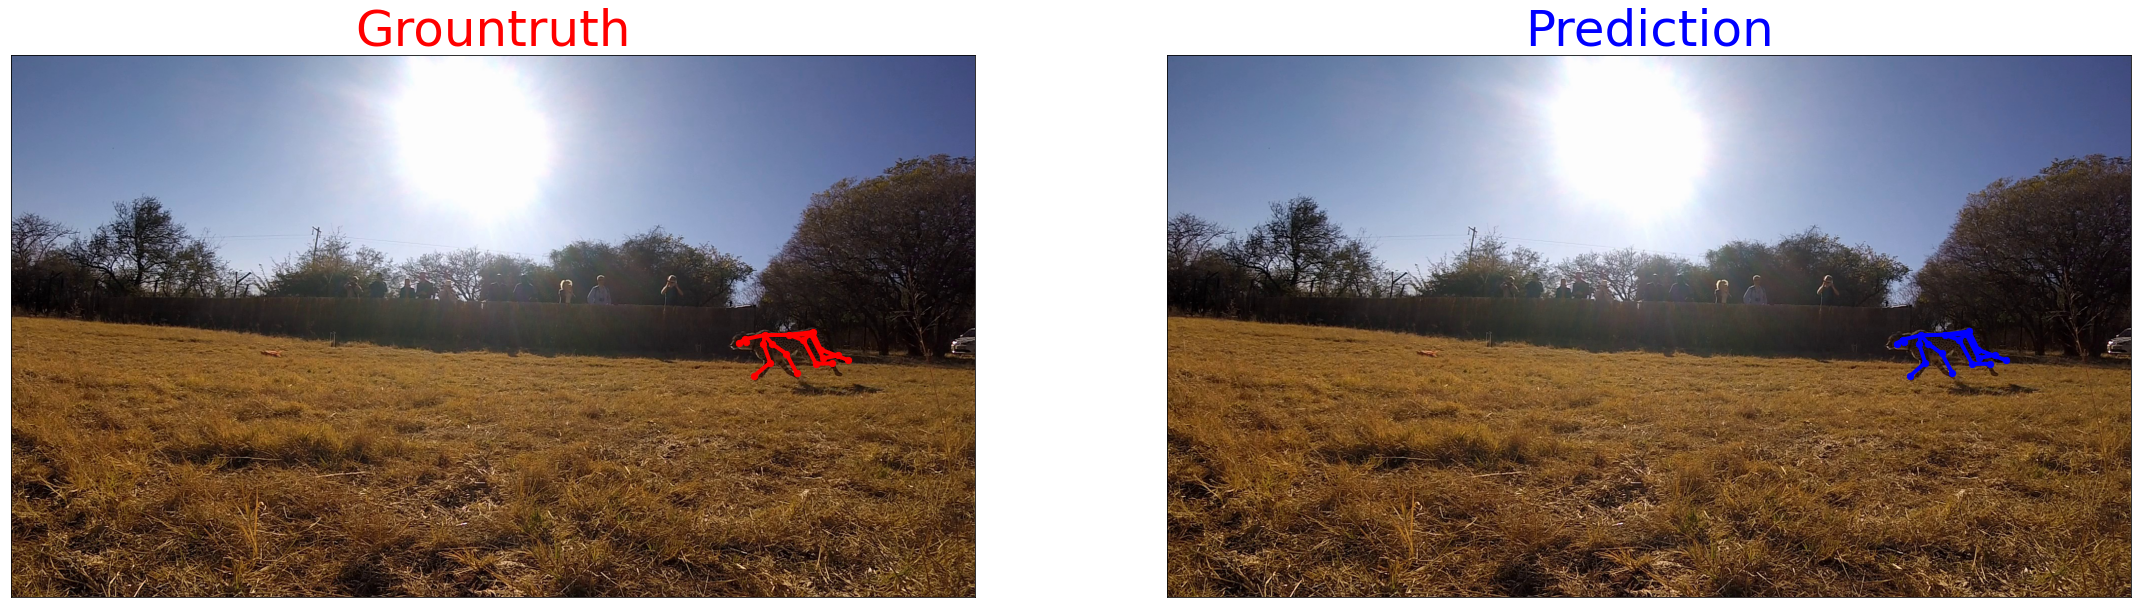

In [26]:
""" Plot the 2D predictions """
""" P.S.: Please choose the camera view """
camera_view = 4
if len(image_paths_cam[0]) > 0:
    im = img.imread(image_paths_cam[camera_view][frame_idx])
    fig = mv_nrsfm_kernel.gen_image(
        im,
        GT_2D[camera_view, frame_idx, :, :],
        Predictions_2D[camera_view, frame_idx, :, :],
        joint_connections,
)